In [210]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import os
import pandas as pd
from astropy.table import Table
from tqdm import tqdm
import numpy as np
import pickle


try:
    import fitsio
    fitsread= fitsio.read
    fitswrite=fitsio.write
    headerread=fitsio.read_header
    _FITSIO_LOADED = True
    
except ImportError:
    import astropy.io.fits as pyfits
    fitsread= pyfits.getdata
    fitswrite=pyfits.writeto
    headerread=pyfits.getheader
    _FITSIO_LOADED = False


import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import colors
import cmasher as cmr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# df = cat.to_pandas()
# print(cat.info)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cat = Table.read("/data/jdli/sdss/dr17/allStar-dr17-synspec_rev1.fits")


names = [name for name in cat.colnames if len(cat[name].shape) <= 1]

df = cat[names].to_pandas()

print(len(df['GAIAEDR3_SOURCE_ID'].unique()), len(df['APOGEE_ID'].unique()))


In [5]:
gdf = df.copy()
# gdf = gdf.merge(df_raw[['GAIAEDR3_SOURCE_ID', 'tmass_id']])

# mask_labels = (gdf['M_H']>-2.5) & (gdf['M_H']<0.6) &\
#             (gdf['TEFF']>3000) & (gdf['TEFF']<7000) &\
#             (gdf['LOGG']>0.) & (gdf['LOGG']<5.5) &\
#             (gdf['ALPHA_M']>-1) & (gdf['ALPHA_M']<1) & (gdf['ASPCAPFLAG']==0) &\
#             (gdf['LOGG_ERR']<0.1) & (gdf['TEFF_ERR']<50) &\
#             (gdf['ALPHA_M_ERR']<0.02) & (gdf['M_H_ERR']<0.015)

mask_labels = (gdf['TEFF']>3000.) & (gdf['TEFF']<8000) &\
         (gdf['LOGG']>0.) & (gdf['LOGG']<6) &\
         (gdf['M_H']>-3.) & (gdf['M_H']<0.6) &\
         (gdf['ALPHA_M']>-1) & (gdf['ALPHA_M']<1.) &\
         (gdf['LOGG_ERR']<0.05) & (gdf['TEFF_ERR']<50) &\
         (gdf['ALPHA_M_ERR']<0.02) & (gdf['M_H_ERR']<0.02) 

# mask_spec = (gdf['snr_bp10']>100.) & (gdf['snr_bp55']>1.) &\
#             (gdf['snr_rp10']>100.) & (gdf['snr_rp55']>1.)

mask = mask_labels

# print(gdf.shape, gdf[mask_labels].shape, gdf[mask_photo].shape, gdf[mask_spec].shape)
print(gdf[mask].shape)

(506655, 215)


In [6]:
gdf[mask].to_csv("/data/jdli/gaia/ap17_506655.csv", index=False)


In [7]:
# gdf[mask].to_csv("/data/jdli/sdss/dr17/ap17_lbcut.csv", index=False)

adf = gdf[mask].copy(deep=True)

def convert_string_uft8(series):
    return [s.decode('utf-8').strip() for s in series]

adf['APOGEE_ID'] = convert_string_uft8(adf['APOGEE_ID'])
adf['TELESCOPE'] = convert_string_uft8(adf['TELESCOPE'])
adf['FIELD']     = convert_string_uft8(adf['FIELD'])

print(adf['TELESCOPE'].unique(), "\n", adf['FIELD'].unique())

['apo1m' 'apo25m' 'lco25m'] 
 ['calibration' '120+12' '060-75' ... 'K2_C12_083-66_btx' 'sgr_tidal10'
 'K2_C12_089-63_btx']


In [35]:
spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
ava_spec_names = os.listdir(spec_dir)
print(len(ava_spec_names))

cat_spec_names = [f"{i}.fits" for i in adf['APOGEE_ID'].values]
print(len(cat_spec_names))

res_spec_names = list(set(cat_spec_names) - set(ava_spec_names))
print(len(res_spec_names))


420460
506655
45579


In [ ]:
import multiprocessing
import urllib.request

spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
n_split = 219780

def download_spectrum(telescope, field, apogee_id, save_dir=spec_dir):
    
    # if not os.path.exists(save_dir):
    #     print("make dir %s"%save_dir)
    #     os.makedirs(save_dir)
    
    url = f"https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{telescope}/{field}/aspcapStar-dr17-{apogee_id}.fits"
    filename = f"{apogee_id}.fits"
    filepath = save_dir+filename
    
    if not os.path.exists(filepath):
        try: 
            urllib.request.urlretrieve(url, save_dir+filename)
        except Exception:
            print(f"no such a spectra of APOGEE_ID = {apogee_id}")
    

# Number of parallel processes
num_processes = 64

# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    
    pool.starmap(download_spectrum, tqdm(
        zip(adf['TELESCOPE'].values[n_split:], 
            adf['FIELD'].values[n_split:], 
            adf['APOGEE_ID'].values[n_split:],
           ), total=len(adf)-n_split))


 25%|████████████████████████████████████████                                                                                                                        | 126926/506655 [00:19<00:01, 350041.67it/s]

no such a spectra of APOGEE_ID = 2M04574307-6956136


 25%|█████████████████████████████████████████▏                                                                                                                        | 128700/506655 [19:43<1:56:24, 54.11it/s]

no such a spectra of APOGEE_ID = 2M05212631-6551151
no such a spectra of APOGEE_ID = 2M02471041+1518255
no such a spectra of APOGEE_ID = 2M03541578+4923521
no such a spectra of APOGEE_ID = 2M04355574-6225176
no such a spectra of APOGEE_ID = 2M04413325-6748077
no such a spectra of APOGEE_ID = 2M04541314-6854533
no such a spectra of APOGEE_ID = 2M05495723+0407115
no such a spectra of APOGEE_ID = 2M06142745-5537445
no such a spectra of APOGEE_ID = 2M05275931-0045234


 27%|███████████████████████████████████████████                                                                                                                       | 134640/506655 [27:00<2:28:45, 41.68it/s]

no such a spectra of APOGEE_ID = 2M03443741+2508160
no such a spectra of APOGEE_ID = 2M01024987+8449562
no such a spectra of APOGEE_ID = 2M04173779-6824167
no such a spectra of APOGEE_ID = 2M00040457+1438217
no such a spectra of APOGEE_ID = 2M04223186-7315283
no such a spectra of APOGEE_ID = 2M03380539+3254285


 27%|████████████████████████████████████████████▎                                                                                                                     | 138600/506655 [35:48<4:24:45, 23.17it/s]

no such a spectra of APOGEE_ID = 2M05224914-6607483


 27%|████████████████████████████████████████████▎                                                                                                                     | 138600/506655 [36:00<4:24:45, 23.17it/s]

no such a spectra of APOGEE_ID = 2M06184955-0144498


 28%|█████████████████████████████████████████████▌                                                                                                                    | 142560/506655 [39:00<4:23:55, 22.99it/s]

no such a spectra of APOGEE_ID = 2M05194903+2407393
no such a spectra of APOGEE_ID = 2M00573054-7215514
no such a spectra of APOGEE_ID = 2M04415201-7459319
no such a spectra of APOGEE_ID = 2M04363952+5814146
no such a spectra of APOGEE_ID = 2M02312523+3038080


 29%|█████████████████████████████████████████████▉                                                                                                                   | 144540/506655 [50:46<10:47:32,  9.32it/s]

no such a spectra of APOGEE_ID = 2M04151675-7132399


 29%|███████████████████████████████████████████████▍                                                                                                                  | 148500/506655 [52:50<7:25:26, 13.40it/s]

no such a spectra of APOGEE_ID = 2M03562722+7947101


 30%|████████████████████████████████████████████████                                                                                                                  | 150480/506655 [54:10<6:31:07, 15.18it/s]

no such a spectra of APOGEE_ID = 2M05510219+0019184


 30%|█████████████████████████████████████████████████▍                                                                                                                | 154440/506655 [57:30<5:27:18, 17.93it/s]

no such a spectra of APOGEE_ID = 2M04293491+3743164


 31%|█████████████████████████████████████████████████▍                                                                                                              | 156420/506655 [1:01:44<7:40:38, 12.67it/s]

no such a spectra of APOGEE_ID = 2M04475222-6041355
no such a spectra of APOGEE_ID = 2M06254511+5340316


 32%|███████████████████████████████████████████████████▉                                                                                                            | 164340/506655 [1:08:50<5:05:30, 18.68it/s]

no such a spectra of APOGEE_ID = 2M04422581+4713296


 36%|█████████████████████████████████████████████████████████▏                                                                                                     | 182160/506655 [1:32:47<10:07:43,  8.90it/s]

no such a spectra of APOGEE_ID = 2M07360651+2114107


 37%|██████████████████████████████████████████████████████████▍                                                                                                    | 186120/506655 [1:42:40<10:53:28,  8.18it/s]

no such a spectra of APOGEE_ID = 2M06325849+0959468
no such a spectra of APOGEE_ID = 2M07430057+0839236


 38%|████████████████████████████████████████████████████████████                                                                                                    | 190080/506655 [1:44:30<6:19:27, 13.90it/s]

no such a spectra of APOGEE_ID = 2M07541377+3927043


 39%|█████████████████████████████████████████████████████████████▉                                                                                                  | 196020/506655 [1:55:56<9:07:05,  9.46it/s]

no such a spectra of APOGEE_ID = 2M08032142+4820521


 39%|██████████████████████████████████████████████████████████████▊                                                                                                | 199980/506655 [2:10:00<11:58:09,  7.12it/s]

no such a spectra of APOGEE_ID = 2M08193909+7828565


 41%|█████████████████████████████████████████████████████████████████▊                                                                                             | 209880/506655 [2:57:01<24:17:57,  3.39it/s]

no such a spectra of APOGEE_ID = 2M08493799+1540448
no such a spectra of APOGEE_ID = 2M09015999+0210308


 42%|███████████████████████████████████████████████████████████████████                                                                                            | 213840/506655 [3:52:38<48:17:16,  1.68it/s]

no such a spectra of APOGEE_ID = 2M09135063+3412184


 43%|████████████████████████████████████████████████████████████████████▉                                                                                          | 219780/506655 [4:47:51<45:59:23,  1.73it/s]

no such a spectra of APOGEE_ID = 2M09342975+0318229
no such a spectra of APOGEE_ID = 2M09390772+5037403


In [12]:
from astropy.io import fits

def read_spec(fname):
    # pri_header = headerread(fname, 0, memmap=False)
    hdul = fits.open(fname)
    
    try:
        flux = fitsread(fname, 1, memmap=False)
        e_flux = fitsread(fname, 2, memmap=False)
        mask = fitsread(fname, 3, memmap=False)
        tmass_id = hdul[4].data[0][1]
    except:
        flux, e_flux, mask = np.nan,  np.nan,  np.nan 
        tmass_id = np.nan
    # if (len(flux.shape)>1)&(len(e_flux.shape)>1)&(len(mask.shape)>1):
    #     flux, e_flux, mask = flux[0], e_flux[0], mask[0]
    # else:
    #     flux, e_flux, mask = np.nan,  np.nan,  np.nan 
    
    hdul.close()
    return {'tmass_id':tmass_id, 'flux':flux, 'fluxerr':e_flux, 'mask':mask}

x = read_spec(spec_dir+ava_spec_names[0])
x

{'tmass_id': '2M17332599-3043089',
 'flux': array([0., 0., 0., ..., 0., 0., 0.]),
 'fluxerr': array([0., 0., 0., ..., 0., 0., 0.]),
 'mask': array([0., 0., 0., ..., 0., 0., 0.])}

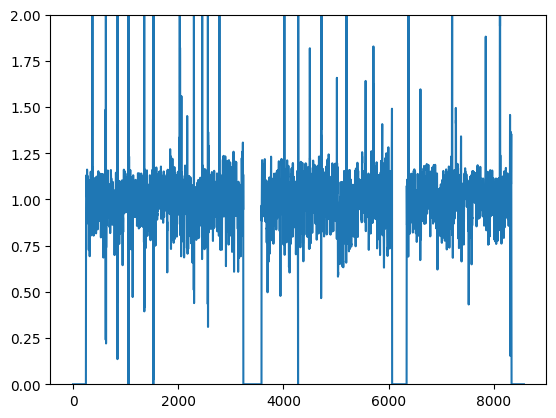

In [13]:
import matplotlib.pyplot as plt

x = read_spec(spec_dir+ava_spec_names[0])
plt.plot(x['flux'])
len(x['flux'])
plt.ylim([0., 2]);


In [36]:
spec_dir = "/data/jdli/sdss/dr17/spec_ap17_lbcut/"
ava_spec_names = os.listdir(spec_dir)
print(len(ava_spec_names))

cat_spec_names = [f"{i}.fits" for i in adf['APOGEE_ID'].values]
print(len(cat_spec_names))

res_spec_names = list(set(cat_spec_names) - set(ava_spec_names))
print(len(res_spec_names))


420460
506655
45579


In [18]:
res_spec_names[0].split('.fits')[0]


'2M10220739+3926548'

In [37]:
# Number of parallel processes
num_processes = 64
ava_spec_paths = [spec_dir+s for s in ava_spec_names]


# Create a pool of processes
with multiprocessing.Pool(processes=num_processes) as pool:
    
    result = pool.map(read_spec, tqdm(ava_spec_paths))

 22%|███████████████████████████████████▋                                                                                                                             | 93252/420460 [00:14<00:00, 394375.00it/s]WARNING: File may have been truncated: actual file length (8192) is smaller than the expected size (74880) [astropy.io.fits.file]
    Header size is not multiple of 2880: 18688
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 18688
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    Header size is not multiple of 2880: 18688
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
 29%|███████████████████████████████████████████████▊                                                                                                                   | 123316/420460 [03:16<10:29, 472.21it/s]WARNING: Fi

In [38]:
tmass_ids = [x['tmass_id'] for x in result]
fluxes = [x['flux'] for x in result]
fluxerrs = [x['fluxerr'] for x in result]

pdf = pd.DataFrame({'tmass_id':tmass_ids, 'flux':fluxes, 'fluxerrs':fluxerrs})

pdf = pd.merge(adf, pdf, how='right', right_on='tmass_id', left_on='APOGEE_ID')

print(pdf['tmass_id'].unique())
print(len(pdf))

['2M17332599-3043089' '2M08193149+2220245' '2M21343598+1138358' ...
 '2M05033188-5846004' '2M13555506-6125124' '2M18144453-1320104']
457371


In [39]:
# ind_spec = (pdf['tmass_id']!=np.nan) & (pdf['flux']!=np.nan) & (pdf['fluxerrs']!=np.nan) & (pdf['GAIAEDR3_SOURCE_ID']!=np.nan)
pdf = pdf.dropna(subset=['tmass_id', 'flux', 'fluxerrs', 'GAIAEDR3_SOURCE_ID'])

print(len(pdf))

pdf['GAIAEDR3_SOURCE_ID'] = pdf['GAIAEDR3_SOURCE_ID'].astype(int)


456583


In [437]:
# xp_spec = np.load("/data/jdli/gaia/ap_xp_233985.npy", allow_pickle=True).item()
xp_spec = np.load("/data/jdli/gaia/ap_xp_0415.npy", allow_pickle=True).item()

xp_spec_df = pd.DataFrame(
    {'source_id':xp_spec['source_id'], 
     'tmass_id':xp_spec['tmass_id'],
     'snr_bp':xp_spec['snr_bp'],
     'snr_rp':xp_spec['snr_rp'],
     'xp':list(xp_spec['x']), 'xp_mask':list(xp_spec['x_mask']), 
     'label':list(xp_spec['y']), 'e_label':list(xp_spec['e_y'])}
)
len(xp_spec_df)

412124

In [439]:
print(len(pdf['GAIAEDR3_SOURCE_ID']), len(pdf['GAIAEDR3_SOURCE_ID'].unique()))
print(len(xp_spec_df['source_id']),   len(xp_spec_df['source_id'].unique()))

print(len(pdf['tmass_id']), len(pdf['tmass_id'].unique()))
print(len(xp_spec_df['tmass_id']),   len(xp_spec_df['tmass_id'].unique()))

xp_ap_spec = pd.merge(xp_spec_df, pdf, on='tmass_id')
xp_ap_spec.shape

456583 416350
412124 412124
456583 419672
412124 412124


(404267, 225)

In [294]:
# xp_spec_df['source_id'] = xp_spec_df['source_id'].astype(str)
# pdf['GAIAEDR3_SOURCE_ID'] = pdf['GAIAEDR3_SOURCE_ID'].astype(str)

# xp_ap_spec = pd.merge(xp_spec_df, pdf, right_on='GAIAEDR3_SOURCE_ID', left_on='source_id')


(404267, 223)

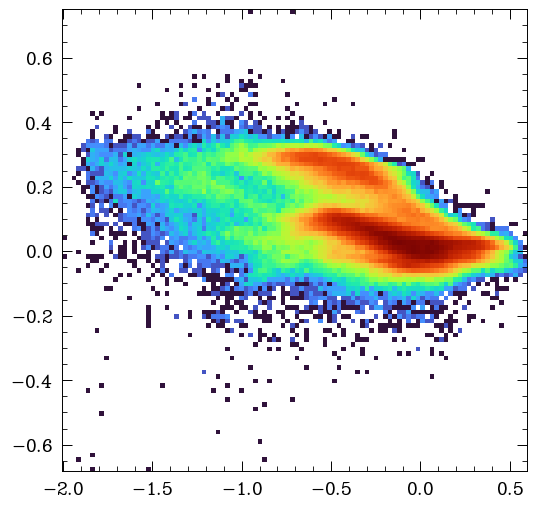

In [120]:
plt.hist2d(xp_ap_spec['M_H'], xp_ap_spec['ALPHA_M'], norm=colors.LogNorm(), bins=100);
# plt.xlim([7500, 3000]);
# plt.ylim([6, 0]);

(404267, 223)


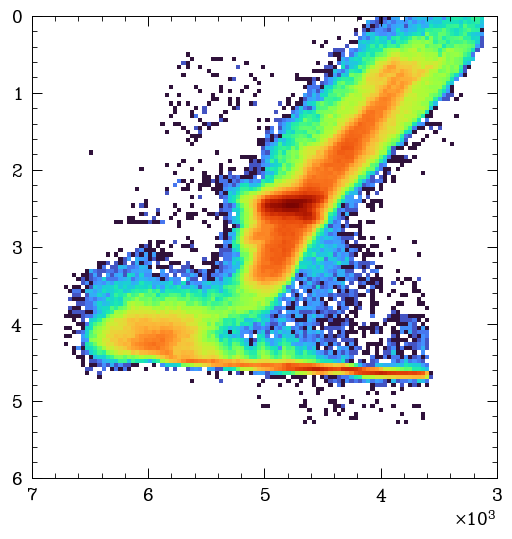

In [122]:
ind_qc = (xp_ap_spec['LOGG_ERR']<0.1) & (xp_ap_spec['TEFF_ERR']<100) &\
         (xp_ap_spec['ALPHA_M_ERR']<0.1) & (xp_ap_spec['M_H_ERR']<0.1) # (ap_df['ASPCAPFLAG']==0)

print(xp_ap_spec[ind_qc].shape)

plt.hist2d(xp_ap_spec['TEFF'][ind_qc], xp_ap_spec['LOGG'][ind_qc], norm=colors.LogNorm(), bins=100);
plt.xlim([7000, 3000]);
plt.ylim([6, 0]);

In [123]:
xp = np.array([x for x in xp_ap_spec['xp'][ind_qc].values])
xp_mask = np.array([x for x in xp_ap_spec['xp_mask'][ind_qc].values])
label = np.array([x for x in xp_ap_spec['label'][ind_qc].values])
e_label = np.array([x for x in xp_ap_spec['e_label'][ind_qc].values])

flux_arr = np.array([x for x in xp_ap_spec['flux'][ind_qc].values])
flux_err_arr = np.array([x for x in xp_ap_spec['fluxerrs'][ind_qc].values])

plt.plot(flux_arr[0])
plt.plot(flux_err_arr[0])
plt.yscale('log')


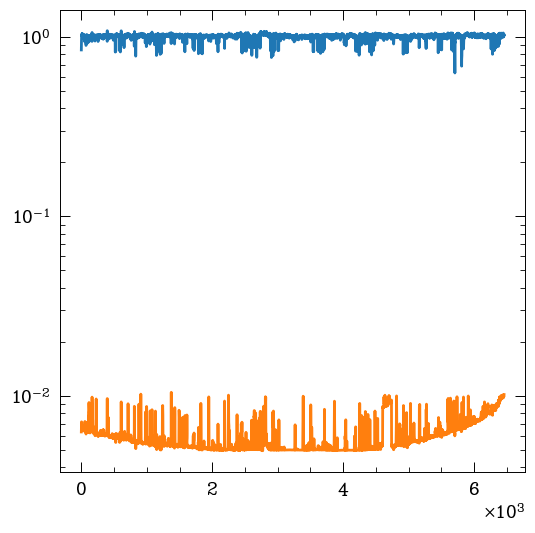

In [125]:
snr = flux_arr * flux_err_arr**-1
ind = snr>100

plt.plot(flux_arr[0][ind[0]])
plt.plot(flux_err_arr[0][ind[0]])
plt.yscale('log')

# plt.plot(flux_arr[0][ind[0]])
# plt.plot(flux_err_arr[0][ind[0]])
# plt.yscale('log')

# data normalization

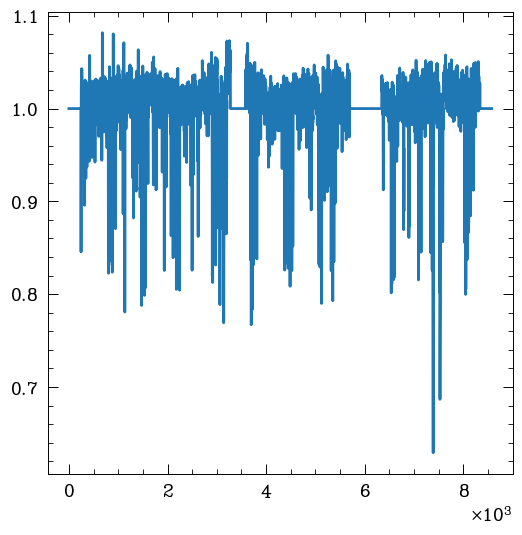

In [126]:
flux_mask = flux_arr

flux_mask[~ind] = 1.

plt.plot(flux_mask[0])

['../models/scaler_ap0415.gz']

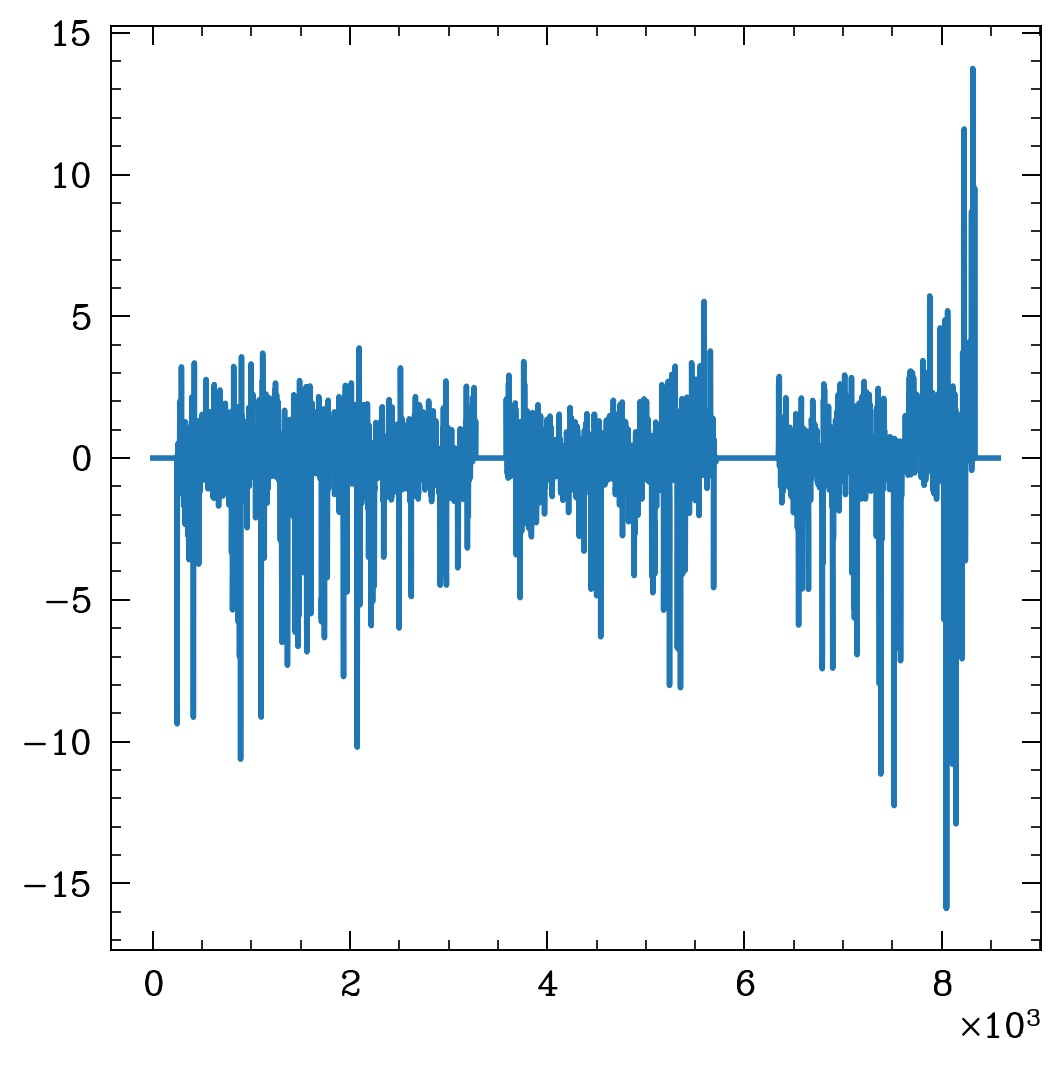

In [221]:
from sklearn import preprocessing
import joblib

scaler_ap = preprocessing.RobustScaler(quantile_range=(25, 75))
norm_flux = scaler_ap.fit_transform(flux_mask)
# norm_flux_err = flux_arr / scaler_ap.scale_

plt.plot(norm_flux[0])
# joblib.dump(scaler_ap, '../models/scaler_ap.gz')

joblib.dump(scaler_ap, '../models/scaler_ap0415.gz')

In [231]:
ind_qc = (xp_ap_spec['LOGG_ERR']<0.1) & (xp_ap_spec['TEFF_ERR']<100) &\
         (xp_ap_spec['ALPHA_M_ERR']<0.1) & (xp_ap_spec['M_H_ERR']<0.1) &\

print(norm_flux.shape, xp_ap_spec.shape, xp_ap_spec[ind_qc].shape)

(404267, 8575) (404267, 225) (404267, 225)


In [ ]:
xp_ap_spec['ap'] = norm_flux.tolist()

save_data = {
    "xp":xp_spec_df['xp'], 
    # 'ap':norm_flux,
    "ap":xp_spec_df['ap'],
    "y":label, 
    "e_y":e_label, 
    "source_id":xp_ap_spec['source_id'].values,
    "tmass_id":xp_ap_spec['tmass_id'].values
}

data_dir = "/data/jdli/gaia/"
fname = "apspec_xp_0415.dump"
# np.savez(data_dir+fname, save_data, protocol=4)

with open(data_dir+fname, 'wb') as pfile:
    pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)
    

# data clean

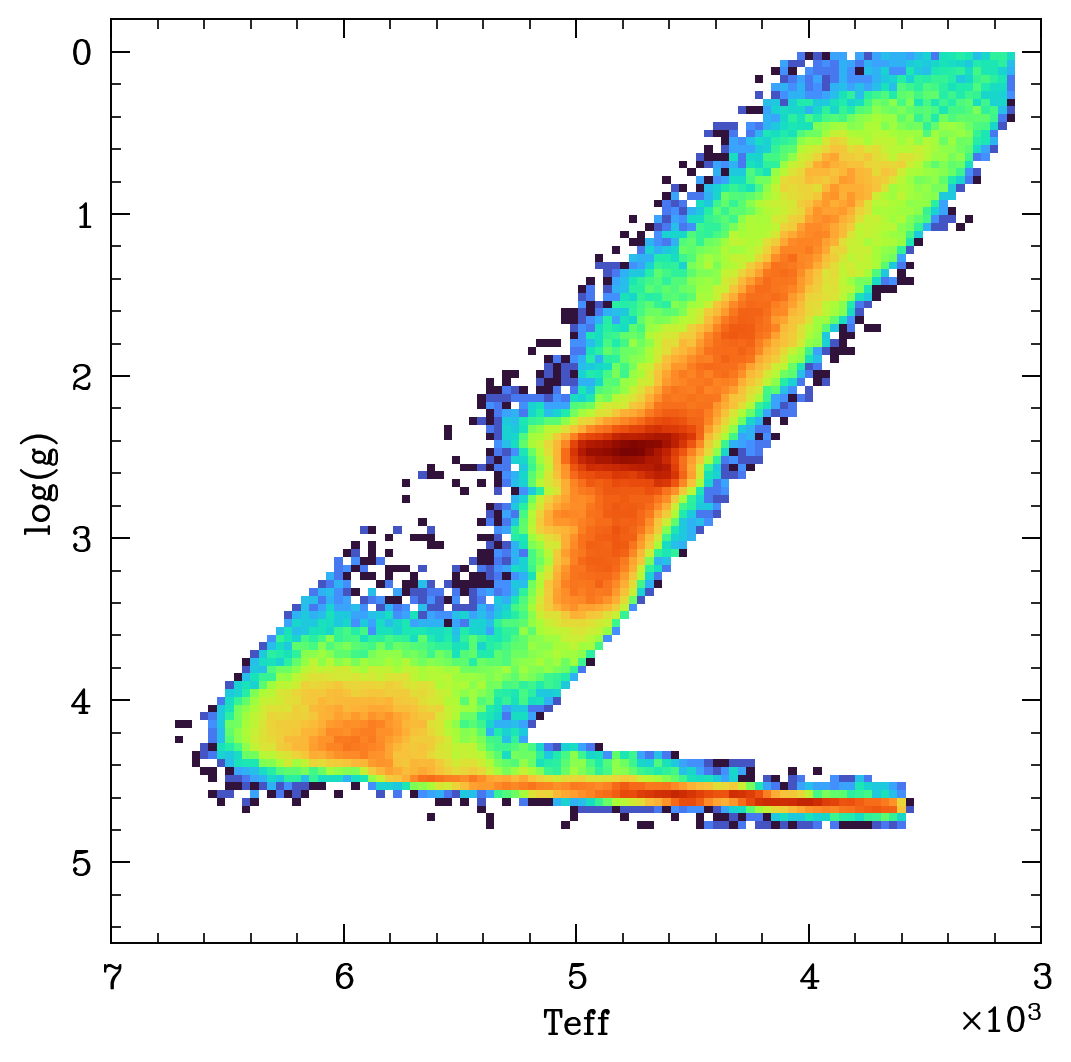

In [422]:
# Define the boundaries for main-sequence and red-giant stars
teff, logg = xp_ap_spec['TEFF'].values, xp_ap_spec['LOGG'].values

ms_select = (logg > 4.2 - 1.5*np.log10(teff/5777)) & (logg < 4.8)

rg_select = (logg<(5/3000)*(teff-3000)+0.5) & (logg>(5/3000)*(teff-3000)-1.9)


# ms_stars = plt.hist2d(xp_ap_spec['TEFF'][ms_select], xp_ap_spec['LOGG'][ms_select], norm=colors.LogNorm(), bins=100)
# rg_stars = plt.hist2d(xp_ap_spec['TEFF'][rg_select], xp_ap_spec['LOGG'][rg_select], norm=colors.LogNorm(), bins=100)
plt.hist2d(teff[ms_select | rg_select], logg[ms_select | rg_select], norm=colors.LogNorm(), bins=100)
plt.xlabel('Teff')
plt.ylabel('log(g)')
# plt.legend((ms_stars, rg_stars), ('Main Sequence', 'Red Giant'))
plt.xlim([7000, 3000]);
plt.ylim([5.5, -0.2]);
plt.show()

In [ ]:
# xp_ap_spec['ASPCAPFLAG'] = xp_ap_spec['ASPCAPFLAG'].astype(int)
def convert_string_uft8(series):
    
    series_str = []
    
    for s in series:
        
        if type(s)==bytes:
            if isinstance(s.decode('utf-8'), str):
                series_str.append(s.decode('utf-8').strip())
                
        elif type(s)==float:
            series_str.append(np.nan)
            
        else:
            print("error")
            
    return series_str


# xp_ap_spec['ASPCAPFLAGS'] = convert_string_uft8(xp_ap_spec['ASPCAPFLAGS'])
xp_ap_spec['ASPCAPFLAGS'] = convert_string_uft8(xp_ap_spec['ASPCAPFLAGS'])
# xp_ap_spec['ASPCAPFLAG']

In [423]:
# bad_flag = ['STAR', 'TEFF', 'VMICRO', 'LOGG', 'M_H', 'ALPHA_M', 'CHI2', 'VSINI', 'NO_GRID']
bad_flag  = ['STAR', 'M_H', 'ALPHA_M', 'TEFF', 'LOGG', 'CHI2', 'NO_GRID']
mask_flag = np.array([not any(digit in str(num) for digit in bad_flag) for num in xp_ap_spec['ASPCAPFLAGS'].values])
# mask_flag = xp_ap_spec['ASPCAPFLAGS'] == np.nan
# mask_flag = [not any(exclude in word for exclude in bad_flag) for lst in xp_ap_spec['ASPCAPFLAGS'].values for word in lst]

# mask_flag = np.array([all(w not in str(item) for w in bad_flag) for item in xp_ap_spec['ASPCAPFLAGS'].values])
# ind_cut = ms_select | rg_select
ind_cut = mask_flag & (xp_ap_spec['SNR']>200)
ind_cut = (ms_select | rg_select) & ind_cut

print(len(xp_ap_spec[ind_cut]))


142130


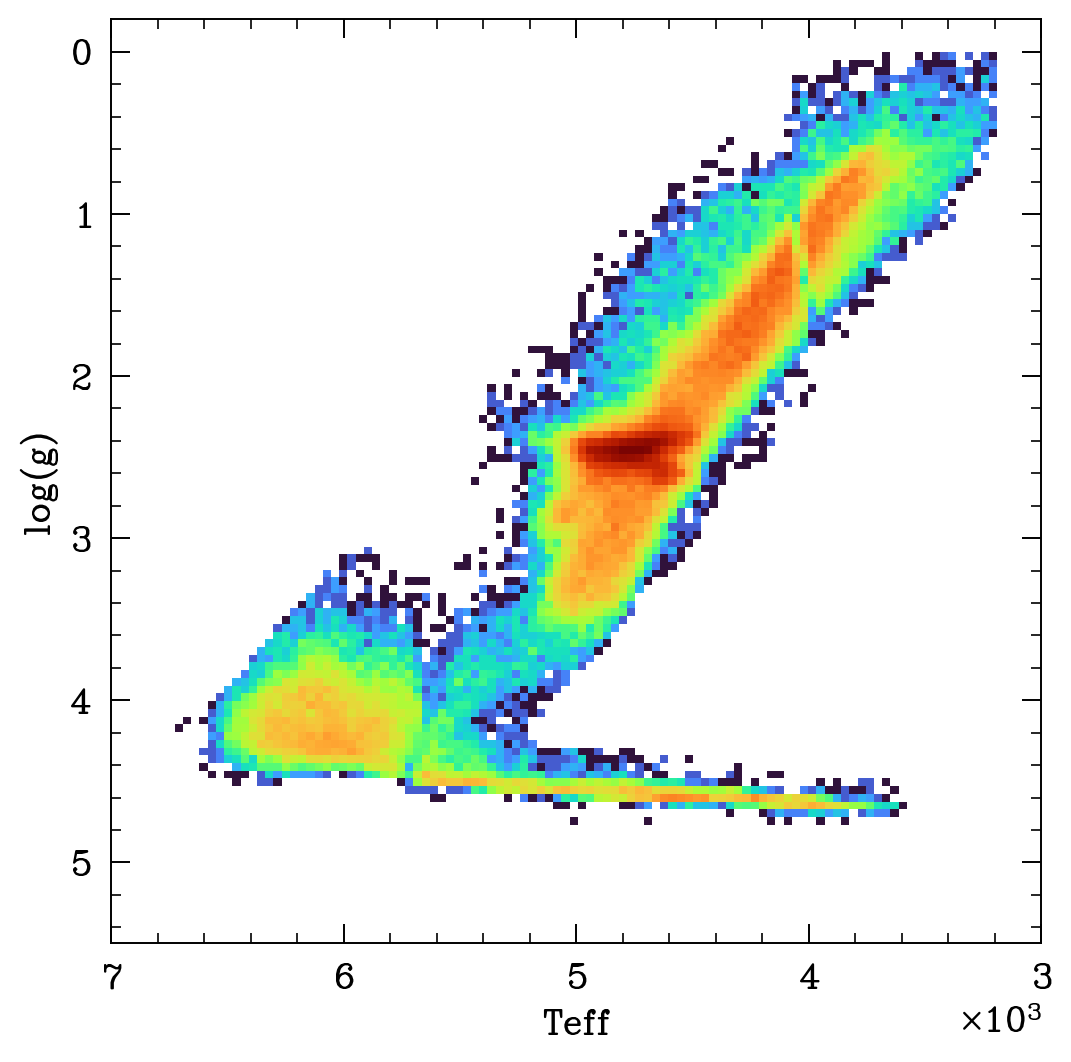

In [424]:
plt.hist2d(teff[ind_cut], logg[ind_cut], norm=colors.LogNorm(), bins=100)
plt.xlabel('Teff')
plt.ylabel('log(g)')
# plt.legend((ms_stars, rg_stars), ('Main Sequence', 'Red Giant'))
plt.xlim([7000, 3000]);
plt.ylim([5.5, -0.2]);


In [448]:
tr_df = xp_ap_spec[ind_cut].reset_index(drop=True)

tr_df.to_csv("/nfsdata/users/jdli_ny/apxp_142130_v2.csv", index=False)

In [450]:
tr_df_lite = tr_df[['TEFF', 'LOGG', 'M_H', 'ALPHA_M', 
                    'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR', 
                    'source_id', 'tmass_id', 'snr_bp', 'snr_rp', 'SNR', 'ASPCAPFLAGS']].copy(deep=True)
tr_df_lite.shape

tr_df.to_csv("/nfsdata/users/jdli_ny/apxp_142130_litev2.csv", index=False)

In [425]:
save_data = {
    "xp":np.array([x for x in xp_ap_spec[ind_cut]['xp'].values]), 
    'ap':np.array([x for x in xp_ap_spec[ind_cut]['ap'].values]), 
    "y": np.array([x for x in xp_ap_spec[ind_cut]['label'].values]), 
    "e_y": np.array([x for x in xp_ap_spec[ind_cut]['e_label'].values]), 
    "source_id":xp_ap_spec[ind_cut]['source_id'].values,
    "tmass_id":xp_ap_spec[ind_cut]['tmass_id'].values,
    "snr_bp":xp_ap_spec[ind_cut]['snr_bp'].values,
    "snr_rp":xp_ap_spec[ind_cut]['snr_rp'].values,
}

data_dir = "/data/jdli/gaia/"
fname = "apspec_xp_cut_0415.dump"

with open(data_dir+fname, 'wb') as pfile:
    pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)
    

# I want a more balanced [M/H] distribution



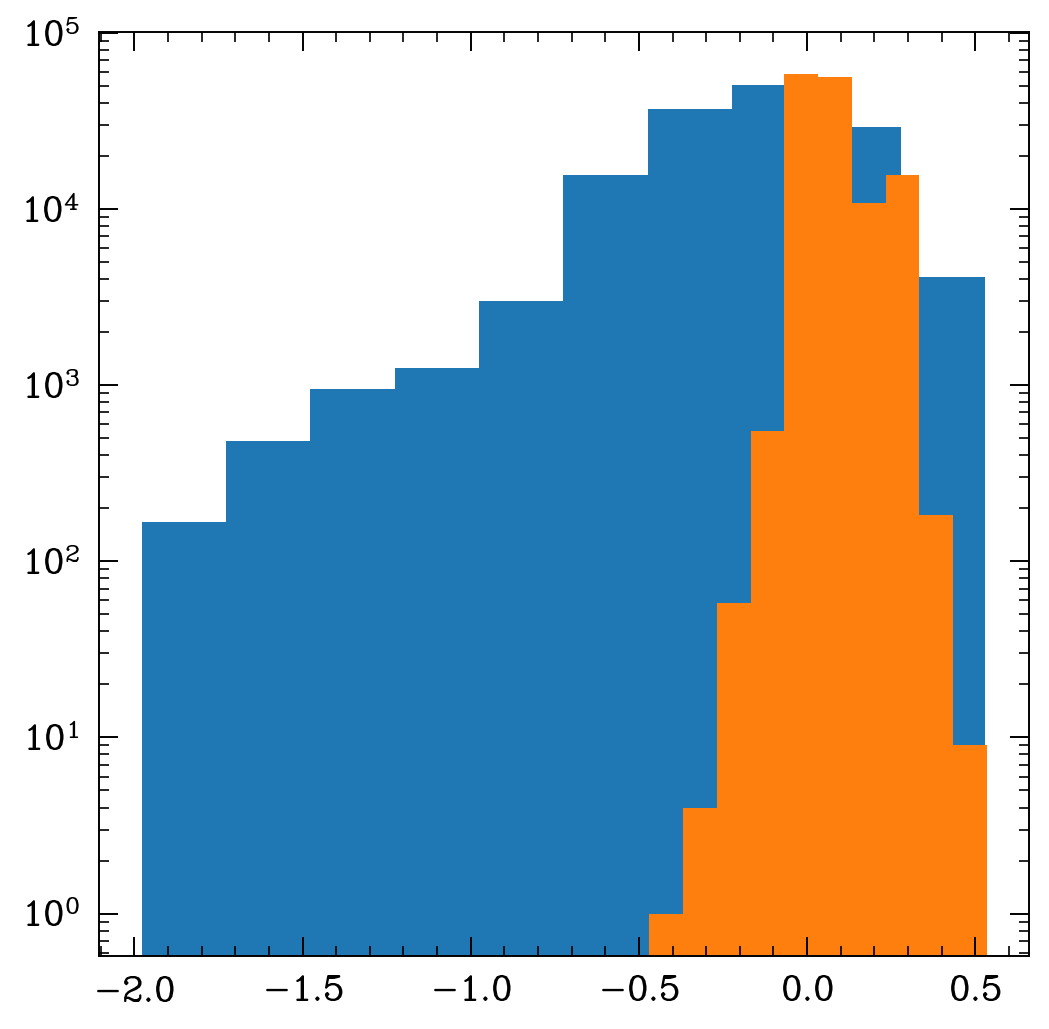

In [426]:
# ind_cut = ms_select | rg_select
# print(len(xp_ap_spec[ind_cut]))
plt.hist(xp_ap_spec['M_H'][ind_cut], log=True);
plt.hist(xp_ap_spec['ALPHA_M'][ind_cut], log=True);

In [427]:
mh_bins = [-2, -1.75, -1.5, -1.25, -1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
xp_ap_spec['mh_bin'] = pd.cut(xp_ap_spec['M_H'], mh_bins)


balanced_spec = xp_ap_spec[ind_cut].groupby('mh_bin').apply(lambda x: x.sample(5000, replace=True))

# Reset the index
balanced_spec = balanced_spec.reset_index(drop=True)

len(balanced_spec)

100000

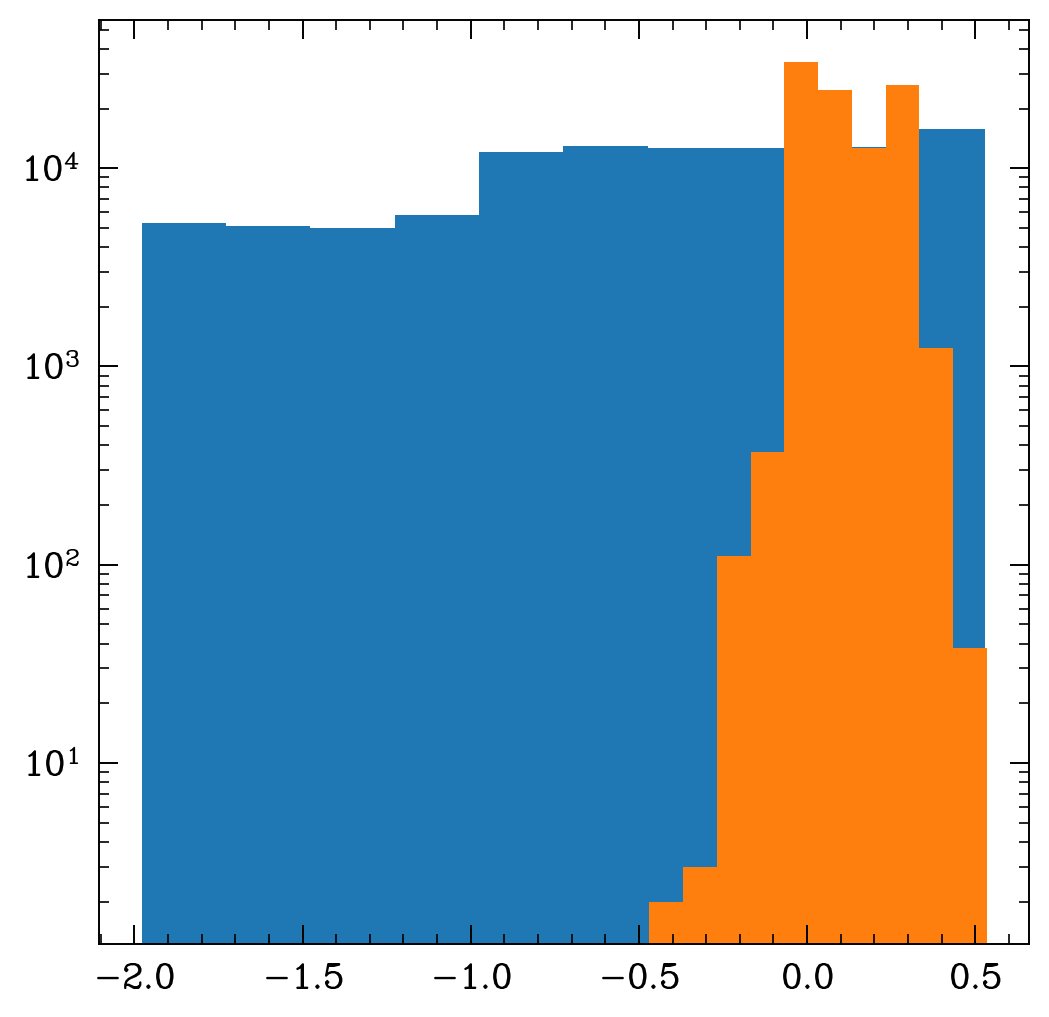

In [428]:
plt.hist(balanced_spec['M_H'], log=True);
plt.hist(balanced_spec['ALPHA_M'], log=True);


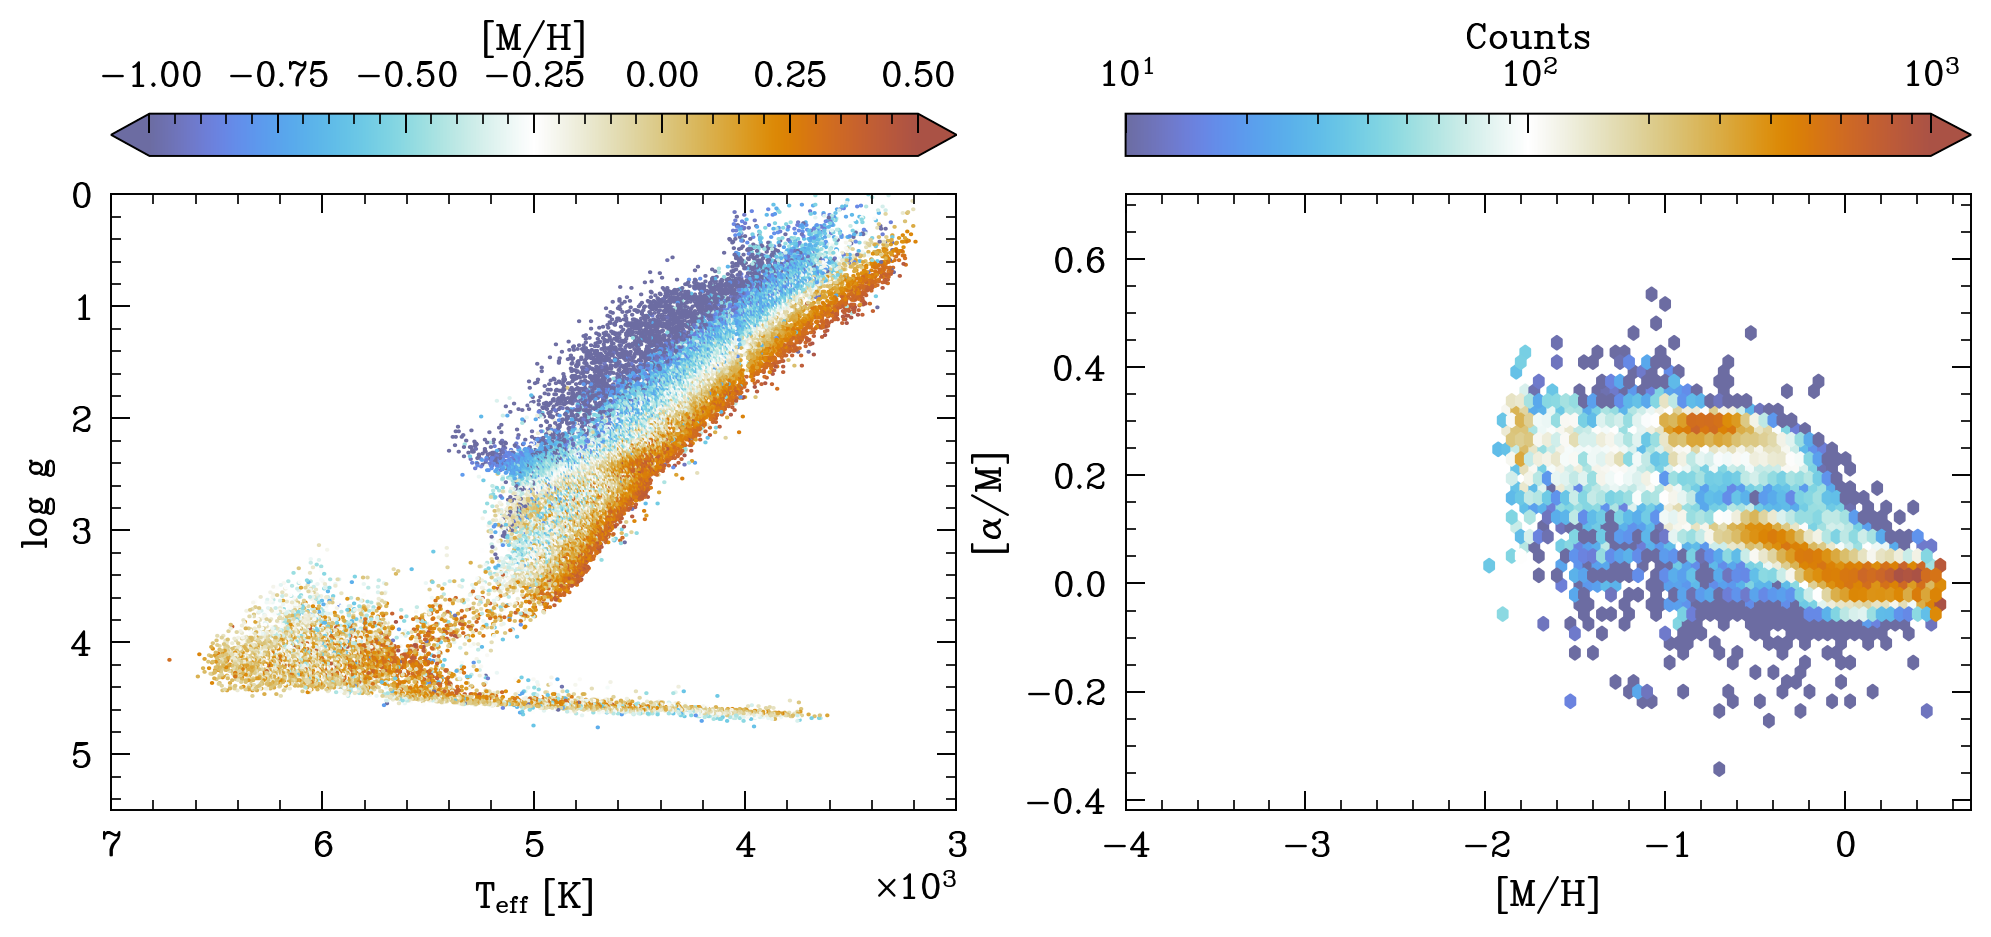

In [429]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12, 5))


hb1 = ax1.hexbin(balanced_spec['TEFF'], balanced_spec['LOGG'], 
                 C=balanced_spec['M_H'], cmap="cmr.prinsenvlag_r", gridsize=500, 
                 vmin=-1, vmax=0.5);

ax1.set_xlim([7000, 3000]);
ax1.set_ylim([5.5, 0]);
ax1.set_xlabel(r"$T_{\rm eff}$ [K]");
ax1.set_ylabel(r"$\log ~ g$");

cbar1 = plt.colorbar(hb1, ax=ax1, extend='both',
                    location='top', orientation='horizontal', pad=0.05)
cbar1.set_label('[M/H]');

hb2 = ax2.hexbin(balanced_spec['M_H'], balanced_spec['ALPHA_M'], 
                 norm=colors.LogNorm(10, 1e3), cmap="cmr.prinsenvlag_r",  
                 gridsize=50);

ax2.set_xlim([-4, 0.7]);
ax2.set_ylim([-0.42, 0.72]);
ax2.set_xlabel("[M/H]"); ax2.set_ylabel(r"[$\alpha$/M]");


cbar2 = plt.colorbar(hb2, ax=ax2, extend='max', 
                     location='top', orientation='horizontal', pad=0.05)
cbar2.set_label(r'Counts');


In [431]:
save_data = {
    "xp":np.array([x for x in balanced_spec['xp'].values]), 
    'ap':np.array([x for x in balanced_spec['ap'].values]), 
    "y": np.array([x for x in balanced_spec['label'][ind_qc].values]), 
    "e_y": np.array([x for x in balanced_spec['e_label'][ind_qc].values]), 
    "source_id":balanced_spec['source_id'].values,
    "tmass_id":balanced_spec['tmass_id'].values
}

data_dir = "/data/jdli/gaia/"
fname = "apspec_xp_balanced_0415.dump"
# np.savez(data_dir+fname, save_data, protocol=4)

with open(data_dir+fname, 'wb') as pfile:
    pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)
    

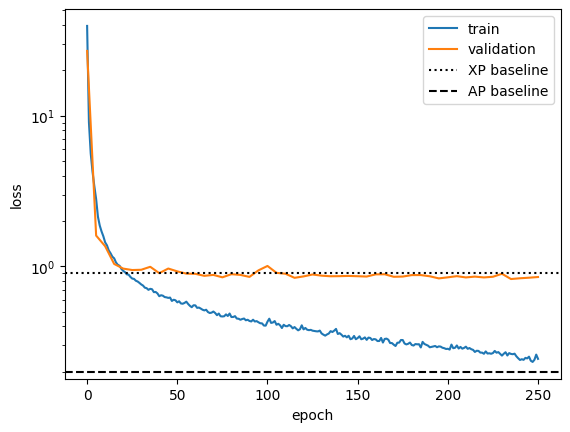

In [133]:
loss_dict = np.load("../check/loss.npy", allow_pickle=True).item()
n_val = np.arange(len(loss_dict['val_loss']))*5


plt.plot(loss_dict['tr_loss'], label='train')
plt.plot(n_val,loss_dict['val_loss'], label='validation')
plt.yscale('log')
plt.ylabel('loss');
plt.xlabel('epoch');


plt.axhline(0.9, label='XP baseline', c='k', ls=':');
plt.axhline(0.2, label='AP baseline', c='k', ls='--');
plt.legend();

In [ ]:
# np.random.seed(27)

# select_no_ap_ind = np.random.choice(reshaped_flux.shape[0], int(0.5*reshaped_flux.shape[0]))
# reshaped_flux_zero = reshaped_flux
# reshaped_flux_zero[select_no_ap_ind,:,:] = 0



# # new_resolution = 200
# new_resolution = 64
# raw_resolution = 8575

# # n_avg = int(raw_resolution / new_resolution)
# n_avg = 128

# # Reshape the data into the desired number of data points for averaging
# reshaped_flux = norm_flux[:,:n_avg*new_resolution].reshape(-1, new_resolution, n_avg)
# # reshaped_fluxerr = norm_flux_err[:,:n_avg*new_resolution].reshape(-1, new_resolution, n_avg)

# # Average the values for each group of data points
# # flux_avg = np.mean(reshaped_flux, axis=2)
# # fluxerr_avg = np.mean(np.abs(reshaped_fluxerr), axis=2)

# print(reshaped_flux.shape)


# save_data = {
#     "xp":xp, 
#     'ap':reshaped_flux_zero,
#     "xp_mask":xp_mask,
#     "y":label, 
#     "e_y":e_label, 
#     "source_id":xp_ap_spec['source_id'].values
# }

# data_dir = "/data/jdli/gaia/"
# fname = "apspec_xp_173344_apzero.dump"
# # np.savez(data_dir+fname, save_data, protocol=4)

# with open(data_dir+fname, 'wb') as pfile:
    
#     pickle.dump(save_data, pfile, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# normspecDict_trlst = []
# normspecDict_vallst= []

# for i in tqdm(range(len(specDict_lst))):
#     d = specDict_lst[i]
    
#     # try:
#     spec = d['flux']
#     spec_err = d['fluxerr']
#     spec_mask = d['mask']

#     norm_spec, norm_spec_err = apogee_continuum(
#         spec, spec_err, bitmask=spec_mask, dr=14
#     )

#     ind = df['2MASS_ID'].str.decode("utf-8")==d['tmass_id']

#     prlx, e_prlx = df[ind]['Gaia_parallax'].values, df[ind]['Gaia_parallax_err'].values
#     prlx_hogg, e_prlx_hogg = df[ind]['spec_parallax'].values, df[ind]['spec_parallax_err'].values
#     mags = df[['Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag']][ind].values

#     data = {'norm_spec':norm_spec, 'norm_spec_err':norm_spec_err, 
#             'mag':mags, 
#             'tmass_id':d['tmass_id'], 
#             'Gaia_parallax':prlx,  'Gaia_parallax_err':e_prlx, 
#             'spec_parallax':prlx_hogg, 'spec_parallax_err':e_prlx_hogg,}

#     if df[ind]['training_set'].values==1:
#         normspecDict_trlst.append(data)
#     elif df[ind]['training_set'].values==0:
#         normspecDict_vallst.append(data)
#     else:
#         print(df['training_set'][ind].values)
            
#     # except:
#     #     print("normalization failed")
        
# print(len(normspecDict_trlst), len(normspecDict_vallst))